## Source 
- [Causal Effects via Propensity Scores - Medium Shawhin Talebi](https://towardsdatascience.com/propensity-score-5c29c480130c)
- [Part 1 - Causal Effects](https://towardsdatascience.com/causal-effects-f30f962ffff3)
- [Part 2 - Causal Inference](https://towardsdatascience.com/causal-inference-962ae97cefda)
- [Part 4 - Causal Discovery](https://towardsdatascience.com/causal-discovery-6858f9af6dcb)
- [Github](https://github.com/ShawhinT/YouTube-Blog)

- **Outcome** $\rightarrow$ variable that we are interested (e.g. profit, incidence of heart disease)
- **Treatments** $\rightarrow$ variables we want to change to influence the outcome variable
- **Covariates** $\rightarrow$ everything else (features) - in clinical example, can be age, weight, height, etc

- Ways to obtain data:
    1. Observational study $\rightarrow$ passively measuring a system without any intervention
    2. Interventional study $\rightarrow$ influence on data generation process for a particular goal (including randomized controlled trials - RCTs)

- Compute effect from observational data - using propensity score
- Subjects with similar propensity score have similar baseline covariates
- Popular propensity score techniques:
    - Matching
    - Stratification
    - Inverse Propability of Treatment Weighting (IPTW)
- Very difficult to compute unbiased causal effects from observational data


## Propensity Score
- Estimates probability a subject receives a particular treatment based on other characteristics (i.e. covariates) - treatment and control group covariates looks similar
- Most popular way to generate propensity score is via **logistic regression**

<img src=https://miro.medium.com/max/700/1*G5RHbRZCzK9yUW_Ni7Sj7g.png width="700">

<img src=https://miro.medium.com/max/1400/1*uM3W3HNBArG1nuXXSZW1zg.png width="700">

With Propensity Score in hand, there are 3 ways to estimate causal effects:

### 1. Matching

- create pairs of treated-untreated pairs with similar propensity score

<img src=https://miro.medium.com/max/1400/1*K480UhgiFpwuygzYAM_DJQ.png width="500">


### 2. Stratification

- split subjects into groups with similar propensity scores

<img src=https://miro.medium.com/max/1400/1*LCRvlPP1VQkK29rOm2Lghg.png width="500">


### 3. Inverse Propability of Treatment Weighting (IPTW)

- Different from other methods, before we used PS to derive subject groups
- In IPTW, use PS to derive _**weights**_ for each subject which are then used to compute treatment effects directly

<img src=https://miro.medium.com/max/1400/1*WTKiqp0VpPUWSLT9Jhw5sQ.png width="500">

<img src=https://miro.medium.com/max/1400/1*scMiqY765Pi-Echdqlvysg.png width="700">



In [1]:
import pickle

In [2]:
import dowhy
from dowhy import CausalModel
import numpy as np

In [5]:
df = pickle.load( open( "data/df_propensity_score.p", "rb" ) )
df

,age,hours-per-week,hasGraduateDegree,inRelationship,isWhite,isFemale,greaterThan50k
0,39,40,0,0,1,0,0
1,50,13,0,1,1,0,0
2,38,40,0,0,1,0,0
3,53,40,0,1,0,0,0
5,37,40,1,0,1,1,0
...,...,...,...,...,...,...,...
32556,27,38,0,0,1,1,0
32557,40,40,0,1,1,0,1
32558,58,40,0,0,1,1,0
32559,22,20,0,0,1,0,0


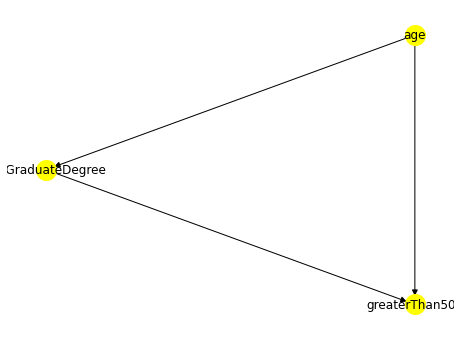

In [6]:
model=CausalModel(
        data = df,
        treatment= "hasGraduateDegree",
        outcome= "greaterThan50k",
        common_causes="age",
        )
model.view_model()

In [8]:
identified_estimand_experiment = model.identify_effect(proceed_when_unidentifiable=True)
identified_estimand_experiment

In [9]:
identified_estimand_experiment.estimand_type

'nonparametric-ate'

In [10]:
ps_method_name_list = ["matching", "stratification", "weighting"]

In [11]:
ps_estimate_dict = {}
ps_estimate_val_list = []
# estimate effect for each method
for ps_method_name in ps_method_name_list:
    ps_estimate =  model.estimate_effect(identified_estimand_experiment,
                                    method_name="backdoor.propensity_score_" + ps_method_name,
                                    confidence_intervals=False,
                                    method_params={})
    # add estimate to dict and ATE to list
    ps_estimate_dict[ps_method_name] = ps_estimate
    ps_estimate_val_list.append(ps_estimate.value)
    
    print(ps_estimate)
    print("\n")

propensity_score_matching


/Users/esirsilvei/.pyenv/versions/torch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.13596160438806992



propensity_score_stratification


/Users/esirsilvei/.pyenv/versions/torch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGraduateDegree,age,U) = P(greaterThan50k|hasGraduateDegree,age)

## Realized estimand
b: greaterThan50k~hasGraduateDegree+age
Target units: ate

## Estimate
Mean value: 0.2500672088597893



propensity_score_weighting
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
         d                                 
────────────────────(E[greaterThan50k|age])
d[hasGraduateDegree]                       
Estimand assumption 1, Unconfoundedness: If U→{hasGraduateDegree} and U→greaterThan50k then P(greaterThan50k|hasGradua

/Users/esirsilvei/.pyenv/versions/torch/lib/python3.10/site-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
